In [24]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../../')

import os
import json
import math
import sys
from collections import defaultdict

from typing import List, Optional, Union, Dict

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import torch
import torch.utils.data
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, BatchEncoding, PreTrainedTokenizerBase

from multitask_nlp.settings import DATASETS_DIR

dataset_path = DATASETS_DIR / 'multirc'


color_pallette = 'muted'
sns.set_theme(style='whitegrid', font_scale=2, palette=color_pallette, 
              rc={'font.family': 'serif', 'font.serif': 'Times New Roman', 'mathtext.fontset': 'dejavuserif'})

DEFAULT_RANDOM = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)
print(f"Tokenizer {model_name} loaded.")

Tokenizer bert-base-uncased loaded.


In [7]:
texts = []

with open(dataset_path / 'train.jsonl') as f:
    for l in f:
        data = json.loads(l)
        texts.append(data['passage']['text'])

In [8]:
text_tokenized = tokenizer(
    texts,
    add_special_tokens=True,
    return_token_type_ids=False,
    return_attention_mask=False,
    truncation=False,
    padding=False,
    return_length=True
)
text_tokens = text_tokenized['input_ids']
lengths = text_tokenized['length']


df = pd.DataFrame({'text': texts, 'length': lengths})

Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors


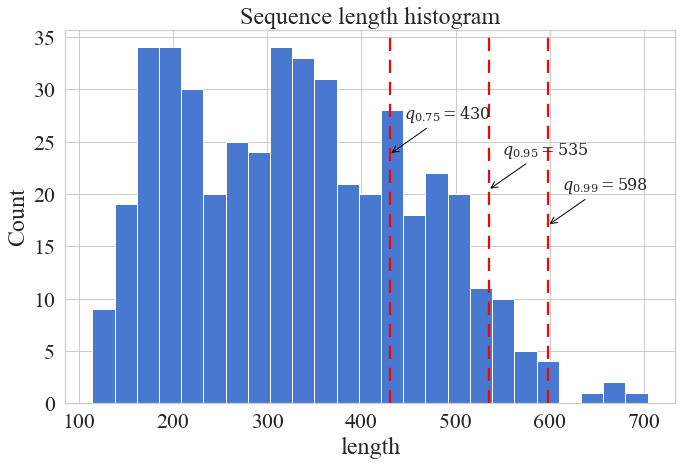

In [9]:
# Seuqence length histogram
fig, ax =plt.subplots(figsize=(10, 7))

sns.histplot(x='length', data=df, ax=ax,  alpha=1.0, bins=25)

_, right_lim = ax.get_xlim()
text_offset = 0.02 * right_lim

max_val = max([p.get_height() for p in ax.patches])
for i, (q, ls) in enumerate(zip([0.75, 0.95, 0.99], [(0, (5, 3)), (0, (5, 6)),  (0, (5, 9))])):
    qv = int(df['length'].quantile(q))
    ax.axvline(qv, ls=(0, (6, 4)), lw=2.2, color='red', zorder=3)
    ax.annotate(r'$q_{{{}}}={}$'.format(str(round(q,2)), qv), xy=(qv, max_val * (0.7 - i*0.1)), 
                 xytext = (qv + text_offset, max_val *  (0.8 - i*0.1)),
                 arrowprops=dict(arrowstyle = "->", color='black'), fontsize=16, zorder=4)

ax.set_title(f'Sequence length histogram')
fig.tight_layout()

In [26]:
texts_dicts = []

with open(dataset_path / 'train.jsonl') as f:
    for l in f:
        data = json.loads(l)
        texts_dicts.append(data)
        
train_texts, dev_texts = train_test_split(texts_dicts, test_size=85, random_state=DEFAULT_RANDOM)


# We take as a test set valid split, cause MultiRC is SuperGLUE benchmark dataset and the real test
# split has no ground truth labels
test_texts = []
with open(dataset_path / 'val.jsonl') as f:
    for l in f:
        data = json.loads(l)
        test_texts.append(data)

In [29]:
for split, texts_dicts in zip(['train', 'dev', 'test'], [train_texts, dev_texts, test_texts]):
    records = []
    for data in texts_dicts:
        text = data['passage']['text']
        text_id = data['idx']
        for q in data['passage']['questions']:
            quastion = q['question']
            question_id = q['idx']
            for answer in q['answers']:
                answer_text = answer['text']
                answer_id = answer['idx']
                label = answer['label']

                record_id = f'{split}_{text_id}_{question_id}_{answer_id}'
                record = {
                    'id': record_id,
                    'question_answer': quastion + ' ' + answer_text,
                    'passage': text,
                    'label': label
                }
                records.append(record)
                
    df = pd.DataFrame.from_records(records)
    df.to_csv(dataset_path / f'{split}_data.csv', index=False)